### Libraries and Modules

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io, restoration, filters#, feature
from PIL import Image
from ipywidgets import interact, widgets


# Modules
from RICM_VESICLE import RICM
from FITTING import Fit_Gaussian

# Functions
def avg_movie(movie, l=2, show_dim=True):
    
    # Average each l frames
    movie_consecutive = []
    for i in range(int(movie.shape[0])):
        if movie.shape[0] - i >= l:
            movie_consecutive.append(np.mean(movie[i:i+l], axis=0))

    # Transform the movie into numpy array
    movie_consecutive = np.array(movie_consecutive)
    
    # Show the dimension reduction
    if show_dim == True:
        print("{} --> {}".format(movie.shape, movie_consecutive.shape))
    
    return movie_consecutive

### Determine the Movie

In [2]:
# Determine the Shot and th GUV number
DATA = 'movie-550ms-92'
SHOT, GUV = "", 2

### Read the whole RICM image to determine the base line

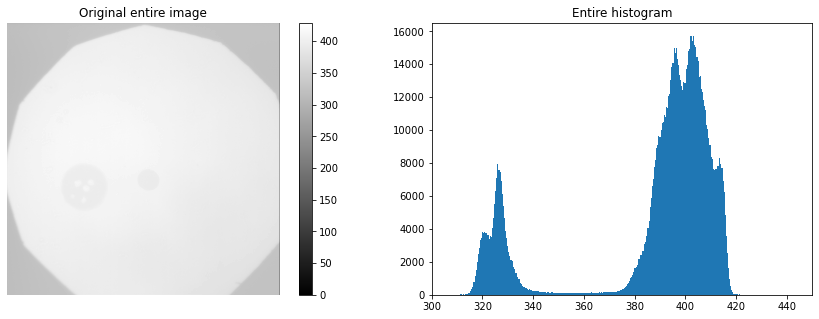

In [3]:
# Read the RICM image
RICM_img = io.imread("20210112_Ecad_dynamics/data/{}.tif".format(DATA)).mean(axis = 0)

# display the image and it's histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original entire image')
plt.imshow(RICM_img, cmap = "gray")
plt.colorbar()

plt.subplot(122)
plt.title('Entire histogram')
plt.hist(RICM_img.ravel(), bins = 1000);
plt.xlim(300,450);

### Read the RICM image for one GUV

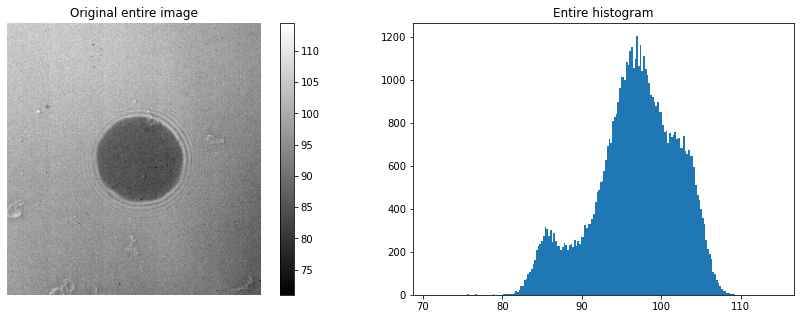

In [4]:
# Read the image
guv = io.imread("20210112_Ecad_dynamics/data/{}{}-{}.tif".format(DATA, SHOT, GUV))

# Subtract the base line
guv = guv - 310

# Take the average
guv_avg = guv.mean(axis = 0)

# display the image and it's histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original entire image')
plt.imshow(guv_avg, cmap = "gray")
plt.colorbar()

plt.subplot(122)
plt.title('Entire histogram')
plt.hist(guv_avg.ravel(), bins = 200);

### Define the RICM model to get the bacground corrected image

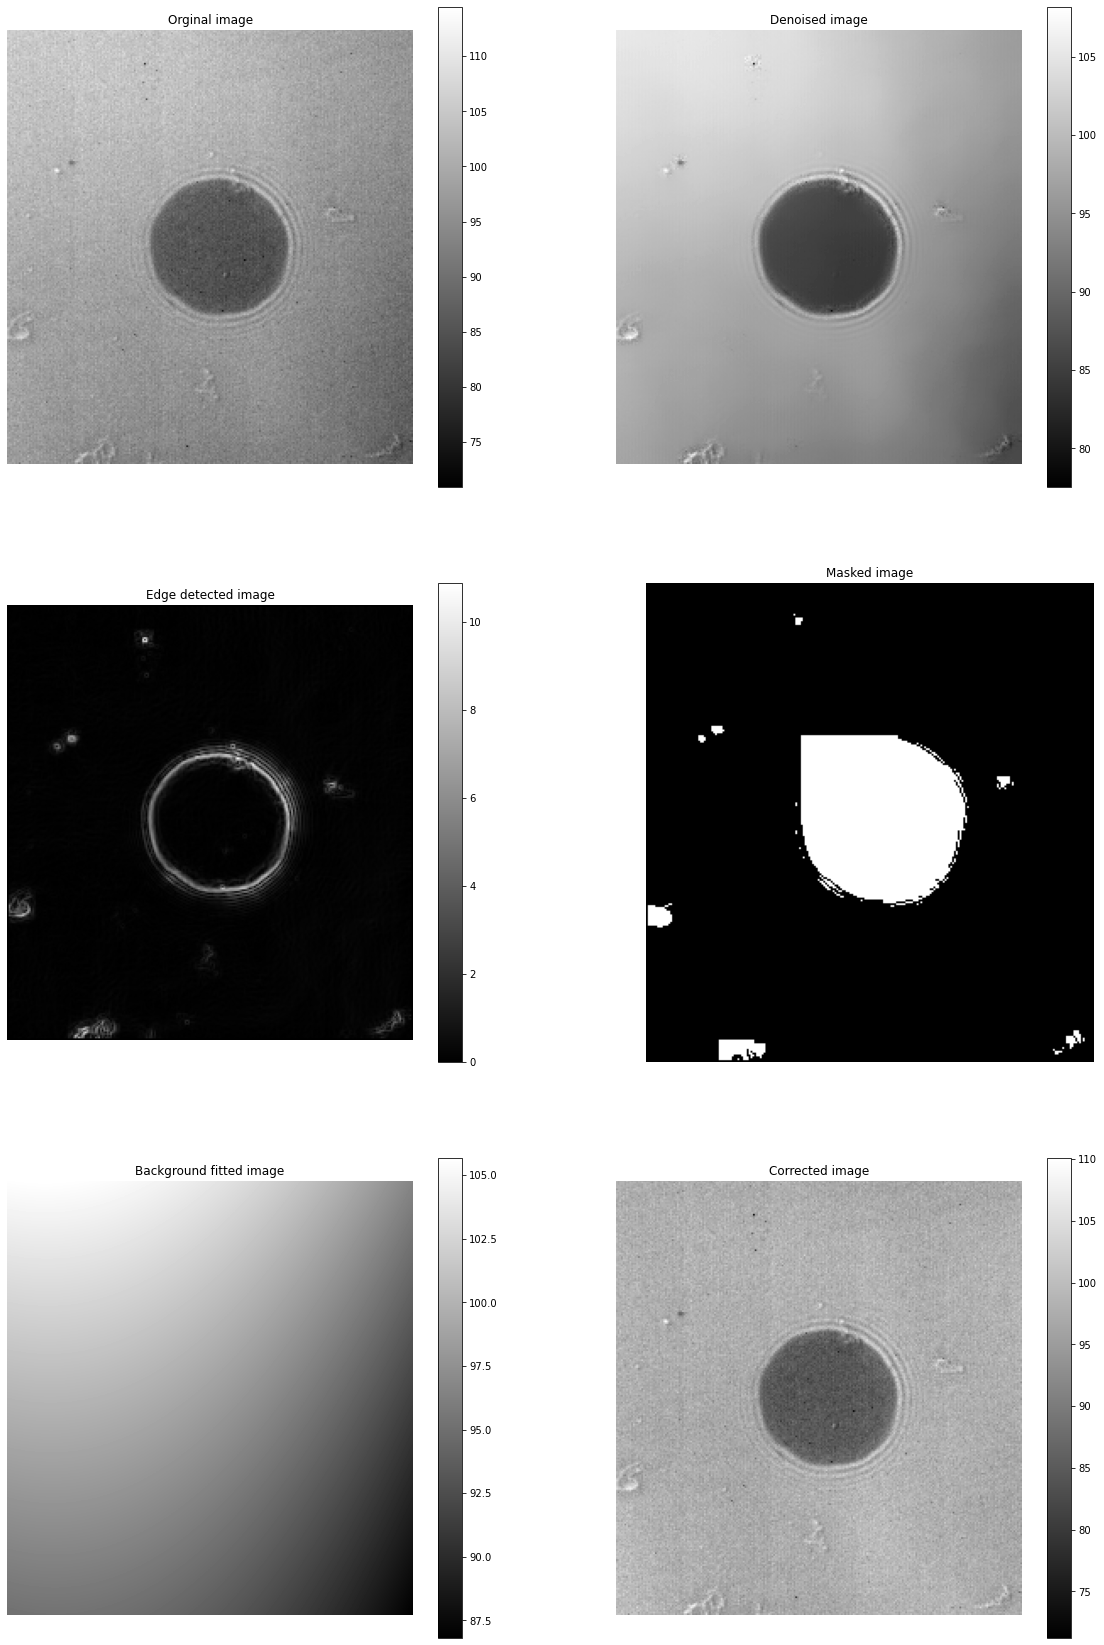

In [5]:
# Define the RICM class with certain n_inner
ricm = RICM(guv_avg, n_inner = 1.344, hole = 2)

# display results
plt.figure(figsize=(20,30))

plt.subplot(321)
plt.axis('off')
plt.title('Orginal image')
plt.imshow(guv_avg, cmap = "gray")
plt.colorbar()

plt.subplot(322)
plt.axis('off')
plt.title('Denoised image')
plt.imshow(ricm.nl_denoise() , cmap = 'gray')
plt.colorbar()

plt.subplot(323)
plt.axis('off')
plt.title('Edge detected image')
plt.imshow(ricm.edge_detection() , cmap = 'gray')
plt.colorbar()

plt.subplot(324)
plt.axis('off')
plt.title('Masked image')
plt.imshow(ricm.mask() , cmap = 'gray')

plt.subplot(325)
plt.axis('off')
plt.title('Background fitted image')
plt.imshow(ricm.background_fitting() , cmap = 'gray')
plt.colorbar()

plt.subplot(326)
plt.axis('off')
plt.title('Corrected image')
plt.imshow(ricm.correct() , cmap = 'gray')
plt.colorbar();

### Take a cosecutive average of the GUV movie

In [6]:
# Take a cosecutive average
guv_consecutive = avg_movie(guv, l=6)

(92, 257, 240) --> (87, 257, 240)


### Measure the area of each frame

In [7]:
%%time

# Define the RICM class with certain n_inner
ricm = RICM(guv_avg, n_inner = 1.344, hole = 2)

# Define the background
background = ricm.background_fitting()
background_correction = background.mean() - background

# Estimating the noise variance of the image
sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[-1] , multichannel = False))

# Get the area of each frame in the averaged movie
area = []
for i in range(guv_consecutive.shape[0]):

    # Apply the Non-local means denoising algorithm
    img_denoised = restoration.denoise_nl_means(guv_consecutive[i],
                                                h = sigma_est,
                                                fast_mode = True,
                                                patch_size = 10,
                                                patch_distance = 20,
                                                multichannel = False)
    
    # Correct the background 
    img_corrected = img_denoised + background_correction

    # Compute the area
    area.append((1 - np.multiply(img_corrected > filters.threshold_otsu(img_corrected), 1)).sum())

# Transform the area into normalized numpy array
area = np.array(area)
#area = area/area.max()

CPU times: user 1min 12s, sys: 13 ms, total: 1min 12s
Wall time: 1min 10s


### Plote and save the area curves

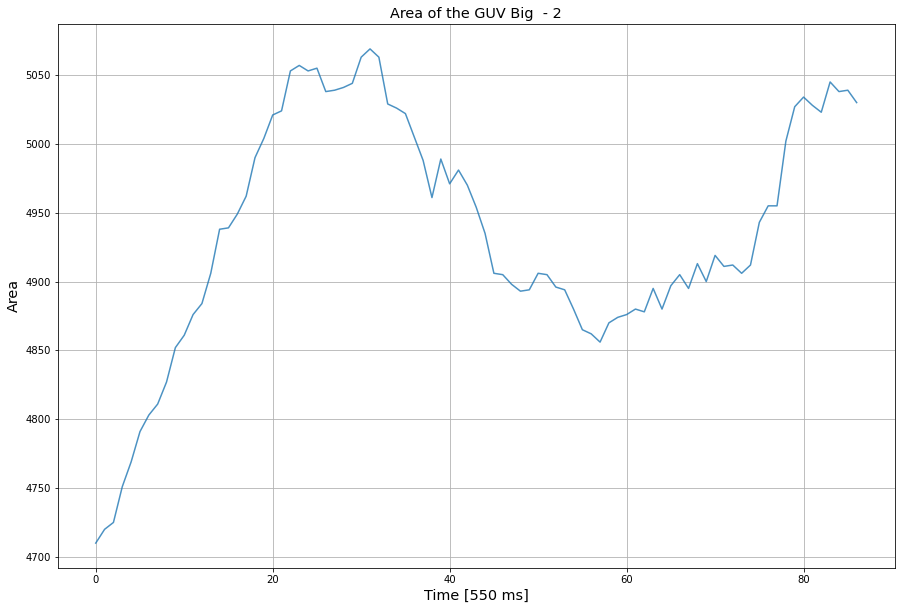

In [8]:
# Define the curve
curve = area[:]

# Plot the curve
plt.figure(figsize=(15, 10))

plt.plot(curve, label = '{}_{}'.format(SHOT, GUV), alpha = 0.8)
plt.title('Area of the GUV Big {} - {}'.format(SHOT, GUV), fontsize= 'x-large')
plt.xlabel('Time [550 ms]', fontsize = "x-large")
plt.ylabel('Area', fontsize = "x-large")
plt.grid()
plt.savefig("20210112_Ecad_dynamics/results/{}{}-{}".format(DATA, SHOT, GUV))

# Save the data
np.save("20210112_Ecad_dynamics/results/{}{}-{}".format(DATA, SHOT, GUV), curve)